In [1]:
import os
os.environ["WANDB_SILENT"] = "true"

import wandb
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from model import MovementPredictor
from tqdm.notebook import tqdm
import numpy as np

import ndpretty
import data_prep
from data_loading import MovementDataset, classify_movement
import autogpu

In [2]:
ndpretty.default()

In [ ]:
run = "cosmic-dust-152"
labels = ["neg", "neutral", "pos"]
values = np.array([-1, 0, 1])[:, np.newaxis]

In [4]:
api = wandb.Api()
runs = api.runs(f"deutschmann/stock-tweets")
wandb_run = list(filter(lambda r: r.name == run, runs))[0]

In [5]:
movements = data_prep.load_movements(classify_threshold_up=wandb_run.config["classify_threshold_up"], classify_threshold_down=wandb_run.config["classify_threshold_down"], min_followers=None, min_tweets_day=wandb_run.config["min_tweets_day"], time_lag=wandb_run.config["time_lag"])

Movement distribution:
 0    1909
 1    1697
-1    1593
dtype: int64


df = pd.DataFrame(mov_lag0, columns=["movement"])
df["stock"] = df["movement"].apply(lambda x: x.stock)
df["tweets"] = df["movement"].apply(lambda x: x.tweets)
df["movement_percent"] = df["movement"].apply(lambda x: x.price["movement percent"])
df["movement_percent_abs"] = df["movement_percent"].abs()

df = df.sort_values(by="movement_percent_abs", ascending=False)

top = 10
for index, row in df[:top].iterrows():
    print(f"{row.stock} {row.movement_percent}")
    row.tweets["text"].apply(print)
    print("--------")

In [6]:
device = autogpu.freest()

model = torch.load(f"artifacts/model_{run}.pt", map_location=device)
model.device = device

# add hocks for tracking activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

model.transformer.register_forward_hook(get_activation('transformer'))
model.follower_layer.register_forward_hook(get_activation('follower_layer'))

In [7]:
ds = MovementDataset(movements, model.transformer_name)
dl = DataLoader(ds, batch_size=1, collate_fn=MovementDataset.coll_samples, shuffle=False)

weights = []
sentiments = []

for tweets, target in tqdm(dl):
    pred = model(tweets)
    weights.append(activation['follower_layer'].cpu().detach().squeeze().numpy())
    sentiments.append(torch.softmax(activation['transformer'].logits, dim=-1).cpu().numpy())

In [8]:
weights = np.concatenate(weights)
sentiments = np.concatenate(sentiments) @ values

tweet_df = None
for mov_id, tweets in enumerate(map(lambda m: m.tweets, movements)):
    tweets["mov_id"] = mov_id
    if tweet_df is None:
        tweet_df = tweets
    else:
        tweet_df = tweet_df.append(tweets)

tweet_df["weight"] = weights
tweet_df["sentiment"] = sentiments
tweet_df["weighted_sentiment"] = tweet_df['sentiment'] * tweet_df['weight']

movement_df = pd.DataFrame([{'stock': o.stock, 'price': o.price["movement percent"]} for o in movements])
movement_df["sent_mean"] = tweet_df.groupby(by='mov_id').mean()['sentiment']
movement_df["sent_weighted"] = tweet_df.groupby(by='mov_id').sum()["weighted_sentiment"]

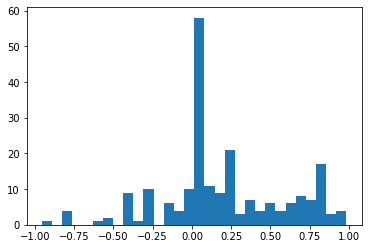

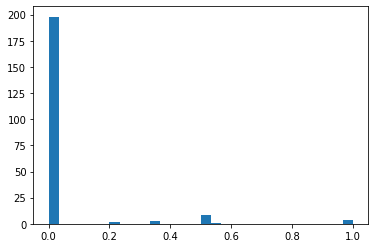

In [9]:
x = plt.figure()
plt.hist(tweet_df["sentiment"], bins=30)
sent_hist = wandb.Image(x)

x = plt.figure()
plt.hist(tweet_df["weight"], bins=30)
weight_hist = wandb.Image(x)

wandb_run = wandb.init(id=wandb_run.id, entity="deutschmann", project="stock-tweets", resume="allow")
wandb_run.log({
    "corr_table": wandb.Table(data=movement_df.corr()),
    "sentiment_hist": sent_hist,
    "weight_hist": weight_hist
})
wandb_run.finish()

In [10]:
# tweet_df.merge(movement_df, left_on='mov_id', right_index=True)

In [11]:
# pd.set_option("display.max_colwidth", 100000)
# tweets